# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import config
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc

# Set constants

In [2]:
# set figure details
figsize = (10, 5)
dpi = 200

# set colors
healthy_color = "steelblue"
nonhealthy_color = 'orange'

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
rc("svg", fonttype="none") 

# Load data

In [9]:
X.loc[("Yang_2020", "SRR6456373")]["k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_cellulosilyticus"]

0.001336699936259

In [3]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features.csv"), index_col=[0, 1])
y = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata.csv"), index_col=[0, 1]).iloc[:, [0]]

# get training set predictions
gmhi2_scores_training_set = pd.read_csv(os.path.join(config.LOG_DIR, "gmhi2_scores_training_set.csv"), index_col=[0, 1])
# get ISV predictions
gmhi2_scores_ISV = pd.read_csv(os.path.join(config.LOG_DIR, "gmhi2_scores_ISV.csv"), index_col=[0, 1])
# get 10 fold
gmhi2_scores_10fold = pd.read_csv(os.path.join(config.LOG_DIR, "gmhi2_scores_10-fold.csv"), index_col=[0, 1])


display(gmhi2_scores_training_set)
display(y.head())

GMHI2
Study_ID  Sample Accession          
GMHI-10   SAMN03283239      1.835237
          SAMN03283266      0.103722
          SAMN03283281      1.116329
          SAMN03283294      1.758818
          SAMN03283288      1.675791
...                              ...
Yang_2020 SRR6456373       -1.029233
          SRR6456374       -0.941967
          SRR6456375       -0.030621
          SRR6456376        0.973798
          SRR6456377       -0.066339

[8069 rows x 1 columns]

PHENOTYPE:Healthy_Nonhealthy
Study_ID Sample Accession                              
GMHI-10  SAMN03283239                              True
         SAMN03283266                              True
         SAMN03283281                              True
         SAMN03283294                              True
         SAMN03283288                              True

In [95]:
def get_cutoff_performance_df(scores, max_cutoff, interval=0.1):
    dict_list = []
    for cutoff in np.arange(0, max_cutoff + interval, interval):
        idx = (abs(scores) >= cutoff).values
        samples_retained = float(idx.sum())
        bal_acc = balanced_accuracy_score(y[idx], scores[idx] > 0)
        dict_list.append({
            "cutoff" : cutoff,
            "samples retained" : samples_retained,
            "bal_acc" : bal_acc
        })
    df = pd.DataFrame(dict_list)
    return df

In [111]:
def plot_performance_vs_cutoff(scores, max_cutoff, left_y_label, filename):
    df = get_cutoff_performance_df(scores, max_cutoff)
    display(df)
    fig, ax1 = plt.subplots(figsize=figsize, dpi=dpi)

    ax2 = ax1.twinx()
    ax1.plot(df["cutoff"], df["bal_acc"], c="steelblue")
    ax2.plot(df["cutoff"], df["samples retained"], c="orange")

    ax1.set_axisbelow(True)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax1.grid(linestyle = '--', linewidth = 0.75)

    ax1.tick_params(axis="both", labelsize=15)
    ax2.tick_params(axis="both", labelsize=15)
    
#     ax1.set_yticks(ax1.get_yticks()[1:-1])

    samples_range = df["samples retained"].max() - df["samples retained"].min()
    acc_range = df["bal_acc"].max() - df["bal_acc"].min()
    
    yticks = [df["samples retained"].min() + (t - df["bal_acc"].min()) * samples_range / acc_range for t in ax1.get_yticks()[1:-1]]
    
    ax2.set_yticks(yticks)

    ax1.set_ylabel(left_y_label, fontsize=15)
    ax2.set_ylabel("Samples retained", fontsize=15)
    ax1.set_xlabel("GMHI2 Magnitude Cutoff", fontsize=15)
    plt.show()

    plt.savefig(os.path.join(config.FIGURE_DIR, filename), bbox_inches='tight')

,cutoff,samples retained,bal_acc
0,0.0,8069.0,0.798853
1,0.1,7719.0,0.811917
2,0.2,7333.0,0.824876
3,0.3,7004.0,0.835330
4,0.4,6691.0,0.846499
5,0.5,6364.0,0.857515
6,0.6,6029.0,0.870530
7,0.7,5664.0,0.882040
8,0.8,5365.0,0.891837
9,0.9,5049.0,0.901703


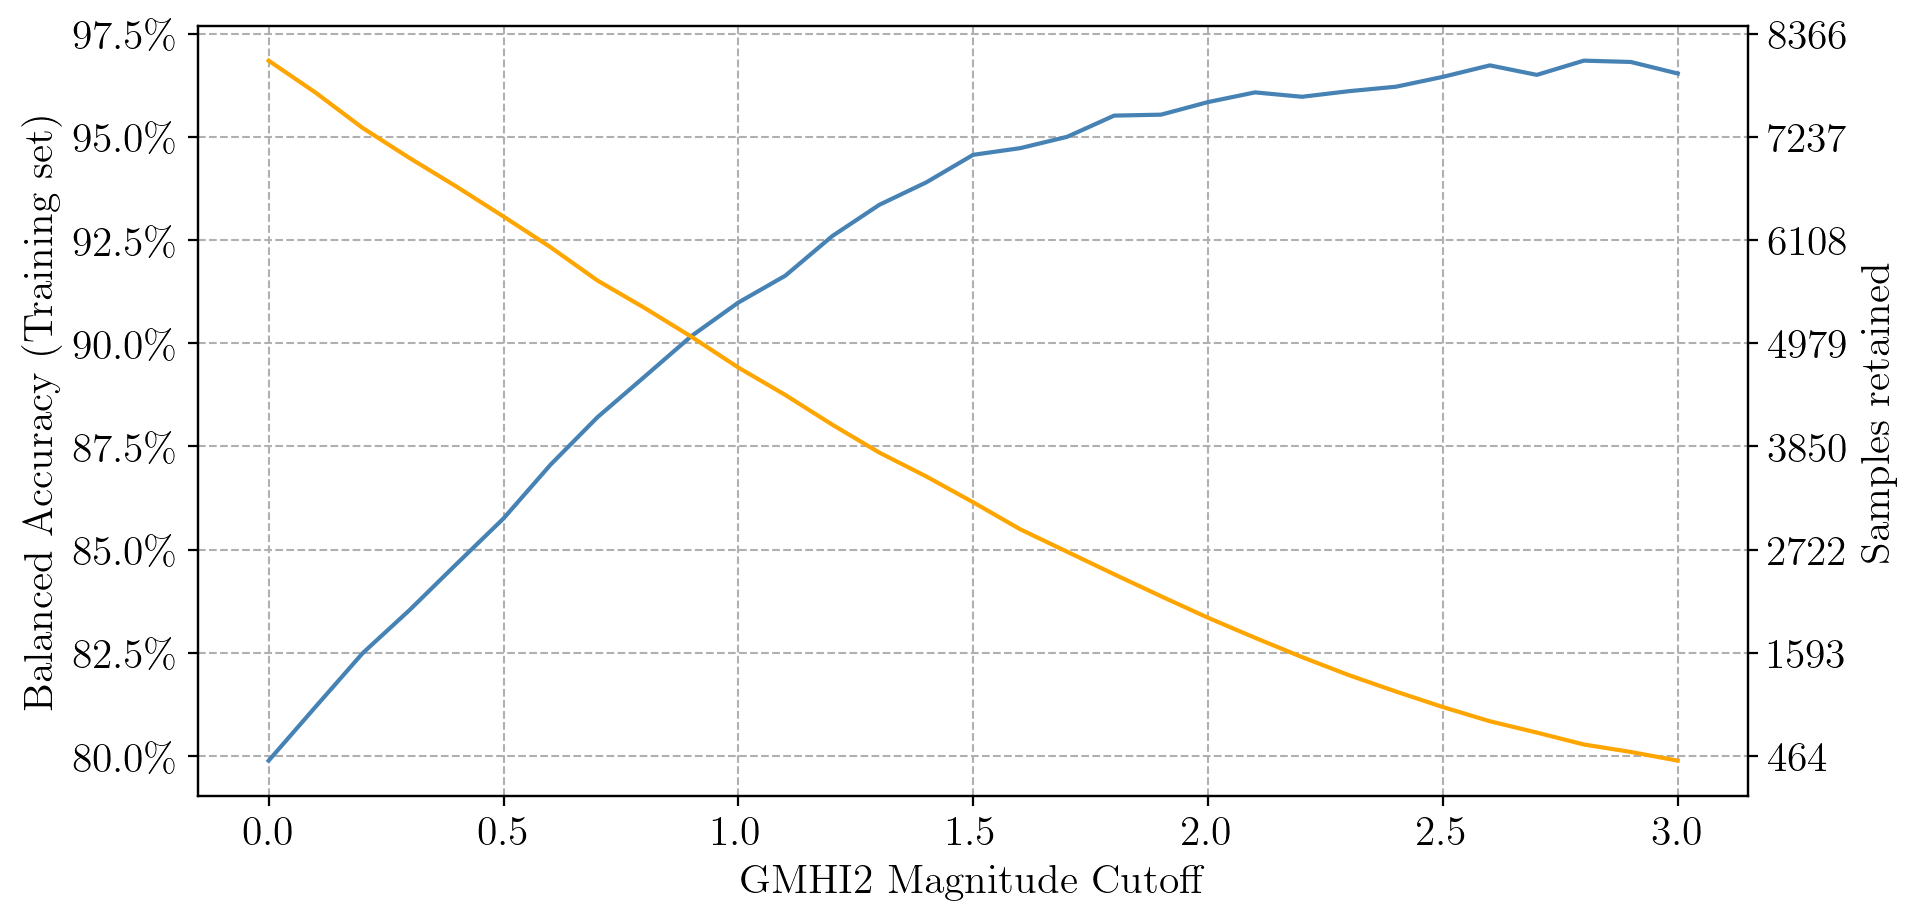

<Figure size 640x480 with 0 Axes>

In [113]:
filename = "performance_vs_cutoff_training.svg"
left_y_label = "Balanced Accuracy (Training set)"
max_cutoff = 3
plot_performance_vs_cutoff(gmhi2_scores_training_set, 3, left_y_label, filename)

In [114]:
training_set_performances = get_cutoff_performance_df(gmhi2_scores_training_set, 3)
training_set_performances = training_set_performances.set_index("cutoff")
training_set_performances.head()

,samples retained,bal_acc
cutoff,,
0.0,8069.0,0.798853
0.1,7719.0,0.811917
0.2,7333.0,0.824876
0.3,7004.0,0.835330
0.4,6691.0,0.846499


In [115]:
training_set_performances.to_csv(os.path.join(config.FIG_DATA_DIR, "1h_training_set_performances.csv"))

,cutoff,samples retained,bal_acc
0,0.0,8069.0,0.757593
1,0.1,7666.0,0.771291
2,0.2,7266.0,0.783056
3,0.3,6882.0,0.795897
4,0.4,6531.0,0.805657
5,0.5,6146.0,0.817848
6,0.6,5758.0,0.829992
7,0.7,5392.0,0.840021
8,0.8,5041.0,0.849685
9,0.9,4690.0,0.859936


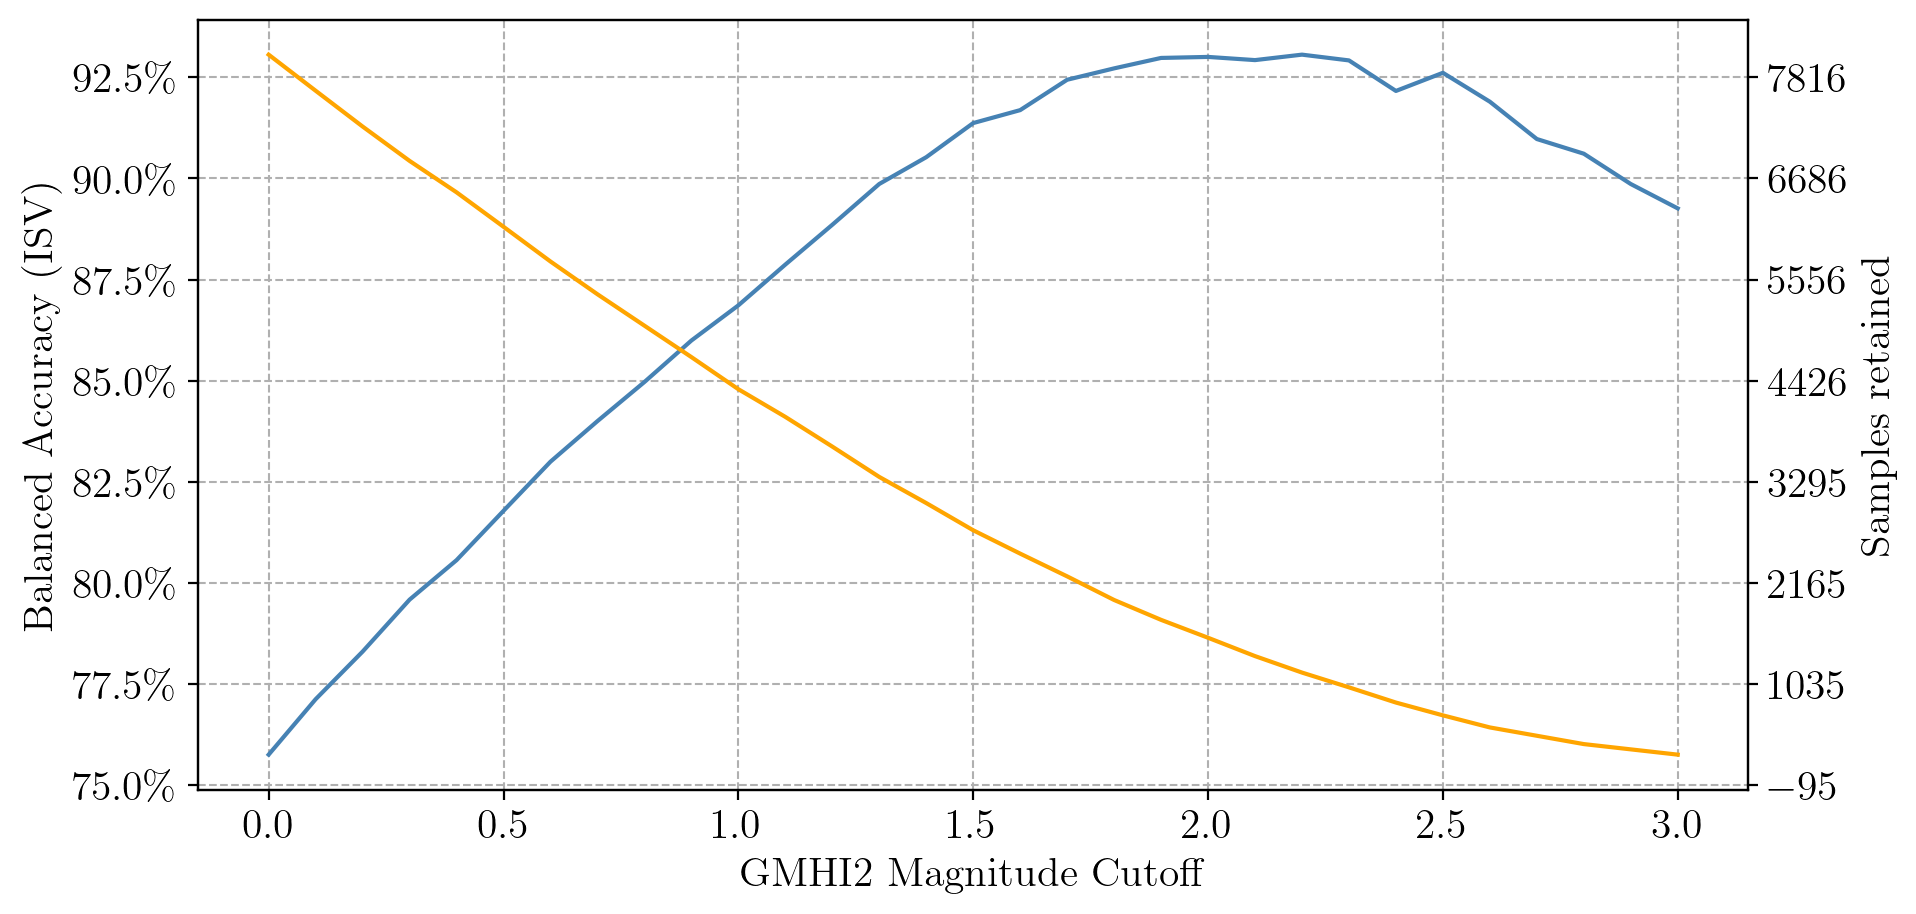

<Figure size 640x480 with 0 Axes>

In [116]:
filename = "performance_vs_cutoff_ISV.svg"
left_y_label = "Balanced Accuracy (ISV)"
max_cutoff = 3
plot_performance_vs_cutoff(gmhi2_scores_ISV, 3, left_y_label, filename)

In [117]:
isv_performances = get_cutoff_performance_df(gmhi2_scores_ISV, 3)
isv_performances = isv_performances.set_index("cutoff")
isv_performances.head()

,samples retained,bal_acc
cutoff,,
0.0,8069.0,0.757593
0.1,7666.0,0.771291
0.2,7266.0,0.783056
0.3,6882.0,0.795897
0.4,6531.0,0.805657


In [118]:
isv_performances.to_csv(os.path.join(config.FIG_DATA_DIR, "2a_isv_performances.csv"))

# Bin samples

In [ ]:
bins = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
healthy_prop = []
nonhealthy_prop = []

for left, right in zip(bins, bins[1:]):
    bin_ = y.iloc[(gmhi2_scores_training_set.values.flatten() > left) & (gmhi2_scores_training_set.values.flatten() < right)]
    healthy_prop.append(bin_.mean())
    nonhealthy_prop.append(1 - bin_.mean())
    

In [ ]:
healthy_prop

In [ ]:
plt.figure(figsize=(10, 7), dpi=200)
ax = plt.gca()

ax.hist(gmhi2_scores_training_set, bins=bins, edgecolor = "black", color="gray", label="# of binned samples")


ax.set_ylabel("Number of samples")
ax.set_xlabel("GMWI2 bins")

ax_new = ax.twinx()

plot_locations = np.array(bins[:-1]) + 0.5

ax_new.plot(plot_locations, healthy_prop, "o-", label="Healthy")
ax_new.plot(plot_locations, nonhealthy_prop, "o-", label="Nonhealthy")

ax_new.set_ylabel("Proportion")

handles = [
    Patch(facecolor="steelblue", edgecolor="k", label="Healthy"),
    Patch(facecolor="orange", edgecolor="k", label="Nonhealthy"),
    Patch(facecolor="gray", edgecolor="k", label="# of binned samples"),
]

plt.legend(handles=handles, prop={'size': 14}, loc=6, handlelength=1.4, handleheight=1.4)

plt.show()

# ROC

In [ ]:
from sklearn.metrics import RocCurveDisplay
from matplotlib import rc
from sklearn.metrics import roc_auc_score

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.figure(figsize=(10, 10), dpi=200)
ax = plt.gca()
RocCurveDisplay.from_predictions(y, gmhi2_scores_training_set, ax=ax, name="Training set")
RocCurveDisplay.from_predictions(y, gmhi2_scores_10fold, ax=ax, name="10-fold cross-validation")
RocCurveDisplay.from_predictions(y, gmhi2_scores_ISV, ax=ax, name="Inter-study validation")

plt.plot([0, 1], [0, 1], "k--", label="Random classifier (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.legend(fontsize=20)
plt.savefig(os.path.join(config.FIGURE_DIR, "ROC.pdf"))


# Overall clinical sensitivity and specificity

In [ ]:
def plot_performance_vs_cutoff2(scores, y, max_cutoff, ax):
    interval = 0.1
    info = []
    
    num_pos = scores[y.iloc[:, 0]].shape[0]
    num_neg = scores[~y.iloc[:, 0]].shape[0]
    
    for cutoff in np.arange(0, max_cutoff + interval, interval):
        rejected_pos = scores[(scores.iloc[:, 0].abs() <= cutoff) & (y.iloc[:, 0])].shape[0]
        rejected_neg = scores[(scores.iloc[:, 0].abs() <= cutoff) & (~y.iloc[:, 0])].shape[0]
        info.append({"cutoff" : cutoff, "pos" : rejected_pos / num_pos, "neg" : rejected_neg / num_neg})
    df = pd.DataFrame(info)
    plt.figure(figsize=(10, 5), dpi=200)
    ax.set_ylabel("Proportion of samples rejected", fontsize=20)
    ax.set_xlabel("GMWI2 Magnitude", fontsize=20)
    ax.plot(df["cutoff"], df["pos"], label="Healthy")
    ax.plot(df["cutoff"], df["neg"], label="Negative")
    ax.legend(fontsize=14)

In [ ]:
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = plt.gca()
plot_performance_vs_cutoff2(gmhi2_scores_ISV, y, 3, ax)
fig.savefig(os.path.join(config.FIGURE_DIR, "rejected_samples.pdf"))

In [ ]:
plt.figure(figsize=(10, 5), dpi=200)
plt.hist(gmhi2_scores_ISV[y.iloc[:, 0]], bins=50, edgecolor="k", alpha=0.5, label="Healthy")
plt.hist(gmhi2_scores_ISV[~y.iloc[:, 0]], bins=50, edgecolor="k", alpha=0.5, label="Nonhealthy")
plt.legend(fontsize=14)
plt.xlabel("GMWI2 (ISV)", fontsize=20)
plt.ylabel("Sample count", fontsize=20)
plt.savefig(os.path.join(config.FIGURE_DIR, "score_distribution.pdf"))